In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

from numpy.linalg import inv, matrix_rank
from pprint import pprint

plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name=''),

In [2]:
import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI

In [3]:
## Generate dataset for Rayleigh's problem
# Function to compute velocity profile u/U as a function of y and t for fixed U and nu
def velocity_profile_rayleigh(y, nu, U, t):
    return U * (1 - erf(y / (2 * np.sqrt(nu * t))))
# Generate samples in the dataset
y_values        = np.linspace(0, 1, 50)                    # Distance from the plate (m)
t_values        = np.linspace(0.01, 5, 20)                 # Time values (s)
n_samples       = 100                                        # Number of samples for U and nu
U_samples       = np.random.uniform(0.5, 1.0, n_samples)   # Plate velocity (m/s)
nu_samples      = np.random.uniform(1e-3, 1e-2, n_samples) # Kinematic viscosity (m^2/s)
u_list          = []
parameters_list = []

for i in range(n_samples):
    U_current   = U_samples[i]
    nu_current  = nu_samples[i]
    for y in y_values:
        for t in t_values:
            u_value = velocity_profile_rayleigh(y, nu_current, U_current, t)
            u_list.append(u_value)
            parameters_list.append([U_current, y, t, nu_current])
u_array          = np.array(u_list).reshape(-1, 1)  
parameters_array = np.array(parameters_list)


In [4]:
## Replace with your own input, dimensionless output, dimension matrix and variable name
Y                = u_array/parameters_array[:,0].reshape(-1,1)  #Output \Pi_o
X                = parameters_array                             #Dimensional input list q                         
D_in             = np.matrix('1 1 0 2;-1 0 1 -1')               #Define D_in matrix, first row "L",second row "T"
num_input        = 1

print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_basis    = D_in.shape[1] - matrix_rank(D_in)
basis_matrices = IT_PI.calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 2
D_in matrix:
 [[ 1  1  0  2]
 [-1  0  1 -1]]
Basis vectors:
matrix([[-1.,  1., -1.,  0.],
        [ 1.,  1.,  0., -1.]])


In [5]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y,
    basis_matrices,
    num_input=num_input,
    estimator="binning",
    estimator_params={"num_bins": 50},
    seed=42
)


input_PI = results["input_PI"]
epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]


------------------------------------------------------------
num of parameters: 2

Using estimator: 'binning' with hyperparameters: {'num_bins': 50}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 2 (seed=42, Sun Sep  7 10:04:23 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -1.318004198098440e+00 1.0e+00 6.30e-01  3e-01  5e-01 0:03.8
    2    600 -1.286403471529037e+00 1.7e+00 5.77e-01  1e-01  2e-01 0:08.9
    3    900 -1.371033419833683e+00 2.0e+00 7.66e-01  7e-02  2e-01 0:15.1
    4   1200 -1.377972055629211e+00 2.7e+00 8.70e-01  5e-02  8e-02 0:21.3
    5   1500 -1.383758224398628e+00 2.6e+00 1.18e+00  6e-02  7e-02 0:27.8
    6   1800 -1.390037015630811e+00 5.2e+00 1.37e+00  4e-02  4e-02 0:34.9
    7   2100 -1.389463949161723e+00 6.3e+00 1.41e+00  2e-02  2e-02 0:41.3
    9   2700 -1.398031798707998e+00 1.1e+01 1.73e+00  2e-02  2e-02 0:54.7
   11   3300 -1.404754049546984e+00 1.2e+01 1.96e+00  1e-02  1e-02 1:08.0
   13   3900 -1.399177

In [6]:
coef_pi_list     = results["input_coef"]
variables        = ['U','y', 't','\\nu'];                       #Define variable name
optimal_pi_lab   = IT_PI.create_labels(np.array(coef_pi_list).reshape(-1, len(variables)), variables)
for j, label in enumerate(optimal_pi_lab):
    print(f'Optimal_pi_lab[{j}] = {label}')
# IT_PI.plot_scatter(input_PI,Y)
# IT_PI.plot_error_bars(input_PI, epsilon,uq)


Optimal_pi_lab[0] = $\frac{y^{1.0}}{t^{0.5} \cdot \nu^{0.5}}$


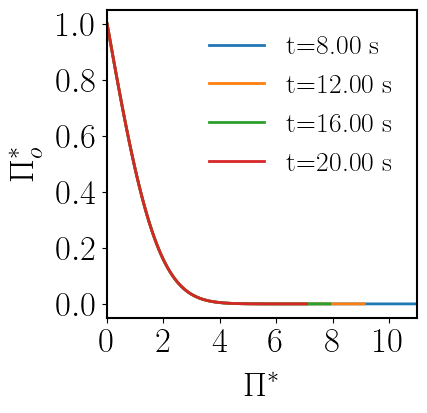

In [7]:
# Plot the comparison
U_fixed  = 1.0       
nu_fixed = 1e-3     
t_values = [ 8, 12, 16, 20]  # Different time values (s)
y        = np.linspace(0, 1, 100)
u_U_profile = np.array([velocity_profile_rayleigh(y, nu_fixed, U_fixed, t) / U_fixed for t in t_values])
y_U_t    = np.array([y / (U_fixed * t) for t in t_values])


# Plot the velocity profiles u/U for different t values
plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
for i, t in enumerate(t_values):
    plt.plot(y/np.sqrt(nu_fixed)/np.sqrt(t), u_U_profile[i], lw=2, label=f't={t:.2f} s')
plt.xlim([0,11])
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.xlabel(r'$\Pi^*$', fontsize=25, labelpad=10)
plt.ylabel(r" $\Pi_o^*$", fontsize=25, labelpad=10)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20,frameon=False)
plt.grid(False)
plt.savefig('Rayleigh_velocity_profile_normalized.eps', dpi=400, bbox_inches='tight',transparent=True)  # You can change the filename and format (e.g., .pdf)
plt.show()

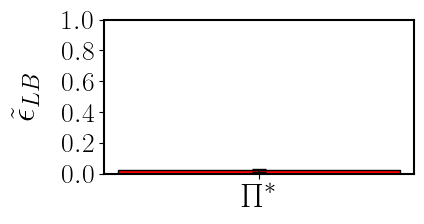

In [8]:
# Plotting the results
plt.figure(figsize=(4, 2))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

x_labels = r"$\Pi^{*}$"
# Use uq_values as the error bars
plt.bar(x_labels, epsilon, yerr=uq, capsize=5, edgecolor='black',color='red')
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel(r'$\tilde{\epsilon}_{L B}$', fontsize=25, labelpad=15)
plt.ylim([0, 1])
plt.savefig('Rayleigh_rank.eps', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

In [9]:
import pickle

workspace = {}
globals_copy = dict(globals())

for key, value in globals_copy.items():
    if not key.startswith('_') and not callable(value) and not hasattr(value, '__module__'):
        try:
            pickle.dumps(value)  # Test if it can be pickled
            workspace[key] = value
        except (TypeError, AttributeError):
            print(f"Skipping {key} - cannot pickle")

with open('output.pkl', 'wb') as f:
    pickle.dump(workspace, f)

Skipping np - cannot pickle
Skipping plt - cannot pickle
Skipping sys - cannot pickle
Skipping os - cannot pickle
Skipping IT_PI - cannot pickle
Skipping pickle - cannot pickle
